# Notebook 2: Solving the Fokker-Planck Equation

In this notebook we solve the Fokker-Planck equation from an initial condition.

In [1]:
import os
import warnings
import time
import tqdm.notebook as tqdm
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import jax
jax.config.update("jax_enable_x64", True)  # use 64-bit precision
import jax.numpy as jnp
import jax.random as jrandom

import diffrax as dfrx
from diffrax import diffeqsolve, WeaklyDiagonalControlTerm, MultiTerm, ODETerm
from diffrax import VirtualBrownianTree, SaveAt, EulerHeun, ShARK
from diffrax import DiscreteTerminatingEvent, SpaceTimeLevyArea

In [2]:
# Random number generator seeds

seed = 422

rng = np.random.default_rng(seed=seed)  # Numpy PRNG
key = jrandom.PRNGKey(seed=rng.integers(2**32))  # JAX key

outdir = "out/"
os.makedirs(outdir, exist_ok=True)

## Generating trajectories of particles in a potential

Recall the potential function and problem setup:

$$
\begin{align*}
    \phi(x,y) &= -\gamma x - \alpha(x - x_c)y^2 + \beta y^4 \\
        \alpha &= 3.0 \\
        \beta &= 0.5 \\
        \gamma &= 2.0 \\
        x_c &= 0.5
\end{align*}
$$
This potential has a single minimum when $x < x_c$ and undergoes a bifurcation at $x=x_c$.
When $x>x_c$, there are two minima. 
We will assume that there is a source defined by 
$$
s_0(x,y) = r \rho_0(x,y)
$$
where $\rho_0$ is a probability distribution defining the support of the source distribution, and $r$ is the injection rate, the rate at which new particles enter into the system.
We will use a multivariate gaussian for $\rho_0$, centered at $\boldsymbol{\mu}_0$ with covariance $\boldsymbol{\Sigma}_0$.
$$
\begin{align*}
    \rho_0 &= \frac{1}{2\pi} |\boldsymbol{\Sigma}_0|^{-1/2} \exp\left( -\frac{1}{2}(\boldsymbol{x} - \boldsymbol{\mu}_0)^T \boldsymbol{\Sigma}_0^{-1} (\boldsymbol{x} - \boldsymbol{\mu}_0) \right) \\
    \boldsymbol{\mu}_0 &= \begin{bmatrix} 0 & 0 \end{bmatrix}^T \\
    \boldsymbol{\Sigma}_0 &= \begin{bmatrix} 0.01 & 0 \\ 0 & 0.2 \end{bmatrix}
\end{align*}
$$

Particles will immediately exit the system upon crossing a boundary $x=x_f$.
We will take
$$
x_f = 2.
$$

Incorporating noise, we'll use for the diffusion tensor
$$
\begin{align*}
    \mathbf{D} &= \begin{bmatrix} D_x & 0 \\ 0 & D_y \end{bmatrix} = \frac{1}{2}\begin{bmatrix} \sigma_x^2 & 0 \\ 0 & \sigma_y^2 \end{bmatrix} \\
    D_x &= 0.01\\
    D_y &= 0.5
\end{align*}
$$

The time evolution of the probability distribution $\rho(x,y,t)$ is then governed by the Fokker-Planck equation
$$
\begin{align*}
    \frac{\partial\rho}{\partial t} &= \nabla\cdot(\rho\nabla\phi) 
        + D_x \frac{\partial^2\rho}{\partial x^2} 
        + D_y \frac{\partial^2\rho}{\partial y^2} 
        + r\rho_0 \\
    &= \rho\nabla^2\phi + \nabla\phi\cdot\nabla\rho
        + D_x \frac{\partial^2\rho}{\partial x^2} 
        + D_y \frac{\partial^2\rho}{\partial y^2} 
        + r\rho_0
\end{align*}
$$
with a condition on the sink boundary
$$
\rho(x,y,t) = 0, \text{ for } x>x_f
$$

In [3]:
#~~~  Define the potential function  ~~~#

alpha = 3.0   # potential parameter alpha (coefficient of y^2)
beta = 0.5    # potential parameter beta (coefficient of y^4)
gamma = 2     # potential parameter gamma (coefficient of x)
x_crit = 0.5  # potential parameter (bifurcation point x=x_c)

def phi(x):
    """Potential function. Input is an array of length 2."""
    x1 = x[0]  # x coord
    x2 = x[1]  # y coord
    x2sq = x2 * x2
    return -gamma*x1 - alpha*(x1 - x_crit)*x2sq + beta*x2sq*x2sq


#~~~  Define the system noise  ~~~#

diffusivity_x = 0.01    # diffusion constant in x
diffusivity_y = 0.5     # diffusion constant in y


#~~~  Define the sources and sinks  ~~~#

x_sink = 4  # particles escape when x >= x_sink

# Gaussian source
source_mean = jnp.array([0, 0], dtype=jnp.float64)
source_sigma_x = 0.05
source_sigma_y = 0.5

source_cov = jnp.array([
    [source_sigma_x, 0], 
    [0, source_sigma_y]
], dtype=jnp.float64)


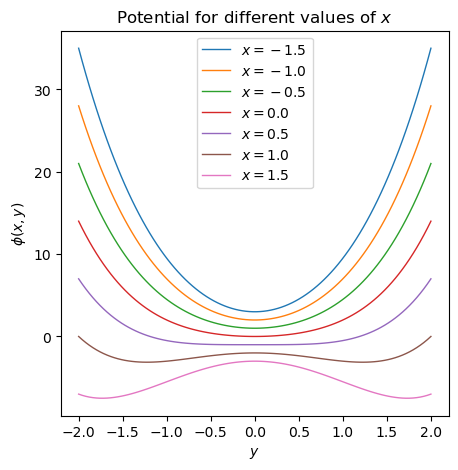

In [4]:
#~~~  Plot the potential for different values of x  ~~~#

fig, ax = plt.subplots(1, 1, figsize=(5, 5))

xvals = [-1.5, -1.0, -0.5, 0.0, 0.5, 1.0, 1.5]

ys = np.linspace(-2, 2, 100)
for x in xvals:
    xs = np.array([x * np.ones(ys.shape), ys]).T
    fs = jax.vmap(phi)(xs)
    ax.plot(ys, fs, linewidth=1, label=f"$x={x}$")

ax.legend()
ax.set_title("Potential for different values of $x$")
ax.set_xlabel("$y$")
ax.set_ylabel("$\phi(x, y)$");

In [5]:
#~~~  Classes for sources  ~~~#

class GaussianSource:

    def __init__(self, mean, cov):
        self.mean = mean
        self.cov = cov

    def center(self):
        return self.mean

    def sample(self, key, n):
        return jrandom.multivariate_normal(
            key, mean=self.mean, cov=self.cov, shape=[n]
        )
    

class PointSource:

    def __init__(self, point):
        self.point = point

    def center(self):
        return self.point

    def sample(self, key, n):
        return jnp.tile(self.point, [n, 1])
    

In [6]:
source = GaussianSource(source_mean, source_cov)
source_point = source.center()  # save the center of the source for plotting

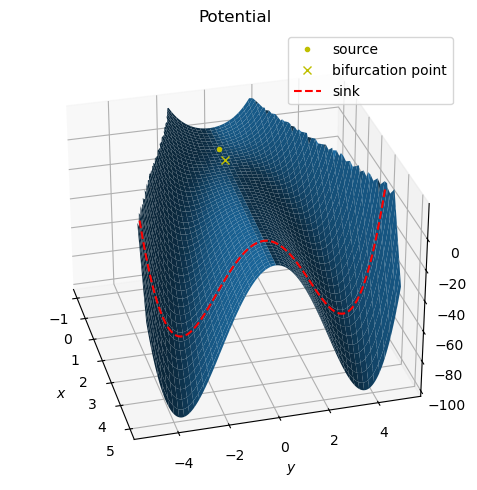

In [7]:
#~~~  Plot the potential function, source, and sink  ~~~#

xlims = [-1, x_sink + 1]
ylims = [-5, 5]

fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(projection='3d', computed_zorder=False)

# Get the grid
x = np.linspace(*xlims, 200)
y = np.linspace(*ylims, 200)
xs, ys = np.meshgrid(x, y)
xy = np.array([xs.flatten(), ys.flatten()]).T

# Compute the potential over the grid
z = jax.vmap(phi)(xy)

# Clipping
clip = 20
clip = 1 + z.max() if clip is None else clip
if clip < z.min():
    warnings.warn(f"Clip value {clip} is below minimum value to plot.")
    clip = z.max()
under_cutoff = z <= clip
plot_screen = np.ones(under_cutoff.shape)
plot_screen[~under_cutoff] = np.nan
z_plot = z * plot_screen

sc = ax.plot_surface(
    xs, ys, z_plot.reshape(xs.shape),
)

# Plot the source point
ax.plot(*source_point, phi(source_point), 'y.', label='source')

# Plot the bifurcation point
ax.plot(x_crit, 0., phi([x_crit, 0]), 'yx', label='bifurcation point')

# Plot the sink curve
ys_sink = np.linspace(*ylims, 100)
xs_sink = x_sink * np.ones(ys_sink.shape)
phi_sink = jax.vmap(phi)(np.array([xs_sink, ys_sink]).T).reshape(xs_sink.shape)
phi_sink = np.where(phi_sink > clip, np.nan, phi_sink)
ax.plot(xs_sink, ys_sink, phi_sink, 'r--', label='sink')

ax.legend()
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.set_title("Potential")

ax.view_init(30, -15)

plt.tight_layout()

In [8]:
#~~~  Define the drift and diffusion functions  ~~~#

# Define drift and diffusion functions
def f(x):
    """Defines the drift, given by the negative gradient of the potential."""
    return -jax.grad(phi)(x)

def g():
    """Defines the diagonal diffusion tensor."""
    return jnp.sqrt(2. * jnp.array([diffusivity_x, diffusivity_y]))


# Wrap the functions above with the required argument signature: (t, y, args).
# This is required by diffrax.
@jax.jit
def drift(t, y, args):
    """Drift term f of the SDE."""
    return f(y)

@jax.jit
def diffusion(t, y, args):
    """Diffusion term g of the SDE. 
    
    Returns an array of length 2 containing sigma_x and sigma_y, defining the 
    diagonal elements of the diffusion tensor according to D_x=sqrt(2 sigma_x).
    """
    return g()

In [9]:
#~~~  Specify solver, stepsize controller, and early halting function.  ~~~#

# Specify a solver
solver = dfrx.ShARK()

# Specify a stepsize controller
stepsize_controller = dfrx.PIDController(
    pcoeff=0.1, icoeff=0.3, dcoeff=0.0, 
    rtol=1e-3, atol=1e-6, 
    dtmin=1e-5, dtmax=1e-2
)

# Early termination function
def check_sink(state, **kwargs):
    return state.y[0] > x_sink

discrete_terminating_event = DiscreteTerminatingEvent(cond_fn=check_sink)


#~~~  Define simulation functions  ~~~#

@jax.jit
def simulate_path(key, t0, y0, tfin, ts_save, dt):
    """Simulate the evolution of a single particle over an interval of time.

    Args:
        key (PRNGKey) : JAX RNG key.
        t0 (float) : start time.
        y0 (Float[Array]) : initial condition.
        tfin (float) : end time.
        ts_save (Float[Array]) : times at which to save the state.
        dt (float) : (initial) solver step size.

    Returns:
        (Float[Array]) : Times at which the state was saved. Shape (nsaves,).
        (Float[Array]) : Saved states. Shape (nsaves, 2). Note that if the cell 
            escapes, the saved state for any subsequent time will contain `inf`. 
    """
    
    # Sample a brownian path.
    key, subkey = jrandom.split(key, 2)
    brownian_motion = VirtualBrownianTree(
        t0, tfin, tol=1e-6, 
        shape=(2,), 
        levy_area=SpaceTimeLevyArea,
        key=subkey
    )

    # Wrap the drift and diffusion terms into a single MultiTerm object.
    terms = MultiTerm(
        ODETerm(drift), 
        WeaklyDiagonalControlTerm(diffusion, brownian_motion)
    )
    
    # We save at the times specified in `ts_save`
    saveat = SaveAt(ts=ts_save)
    sol = diffeqsolve(
        terms,
        solver,
        t0=t0, t1=tfin, dt0=dt,
        y0=y0,
        saveat=saveat,
        stepsize_controller=stepsize_controller,
        discrete_terminating_event=discrete_terminating_event,
        max_steps=None,
    )
    
    # Return the times and states corresponding to `ts_save`
    return sol.ts, sol.ys


@jax.jit
def simulate_ensemble(key, t0s, y0s, tfin, ts_save, dt):
    """Simulate an ensemble of cells, all evolving to the same final time.
    
    Args:
        key (PRNGKey) : JAX RNG key.
        t0s (Float[Array]) : start times of each cell.
        y0s (Float[Array]) : initial state of each cell.
        tfin (float) : end time for all cells.
        ts_save (Float[Array]) : times at which to save the state. All values 
            must be between the maximum of t0s and the end time tfin.
        dt (float) : initial timestep.

    Returns:
        (Float[Array]) : Times at which the state was saved. Shape (ncells, nsaves,).
        (Float[Array]) : Saved states. Shape (ncells, nsaves, 2).
    """
    # Determine the number of cells based on the given initial conditions.
    ncells = y0s.shape[0]
    # Get an array of subkeys to seed each path.
    keys = jrandom.split(key, ncells)
    # Map `simulate_path` across the keys, start times, and initial conditions.
    ts, xs = jax.vmap(simulate_path, (0,0,0,None,None,None))(
        keys, t0s, y0s, tfin, ts_save, dt
    )
    return ts, xs

## Simulating an ensemble and taking a snapshot

In [10]:
def sample_injection_times(key, ntraj, t0, t1):
    """Sample `ntraj` injection times uniformly between `t0` and `t1`.
    """
    injection_times = jrandom.uniform(
        key, (ntraj,), 
        dtype=jnp.float64, 
        minval=t0, 
        maxval=t1,
    )
    return jnp.sort(injection_times)

def sample_injection_times_with_rate(key, rate, t0, t1):
    """Sample injection times occurring at a specified rate.
    """
    injection_times = jnp.array([], dtype=jnp.float64)
    current_time = t0
    batch_size = 1000
    while current_time < t1:
        key, subkey = jrandom.split(key, 2)
        increments = -jnp.log(1 - jrandom.uniform(subkey, (batch_size,))) / rate
        ts = current_time + jnp.cumsum(increments)
        injection_times = jnp.concatenate([injection_times, ts[ts < t1]], 0)
        current_time = ts[-1]
    return injection_times
    

In [11]:
#~~~  Some helper functions to identify escaped cells  ~~~#

def filter_nans(ts, xs):
    """Remove nans/infs from the returned trajectory times and states.
    
    Args:
        ts (Float[Array]) : Saved timepoints. Shape (nsaves,).
        xs (Float[Array]) : Saved states. Shape (nsaves, 2).

    Returns:
        (Float[Array]) : subset of `ts` that are finite.
        (Float[Array]) : corresponding states, a subset of `xs`.
    """
    screen = jnp.isfinite(ts)
    return ts[screen], xs[screen]


def count_nonescaped(snapshot_times, snapshot_states):
    """Count cells remaining in the system.

    Assuming a snapshot is taken at time tstar, cells that have escaped will 
    contain nan or inf in the returned timepoint array. Cells that are remaining
    will have the value tstar instead. An edge case is when the final step puts
    a cell over the edge, in which case the saved time is finite, but the cell
    has technically escaped.
    
    Args:
        snapshot_times (Float[Array]) : Shape (ncells, 1).
        snapshot_states (Float[Array]) : Shape (ncells, 1, 2).

    Returns:
        (int) Number of cells that did NOT escape the system.
    """
    k = snapshot_times.shape[1]
    assert k == 1, f"Expected input to have shape (*,1). Got shape (*,{k})."
    n_nonescaped = np.count_nonzero(
        jnp.logical_and(
            jnp.isfinite(snapshot_times), 
            snapshot_states[:,:,0] < x_sink
        )
    )
    return n_nonescaped


def count_escaped(snapshot_times, snapshot_states):
    """Count cells that escaped the system.

    Assuming a snapshot is taken at time tstar, cells that have escaped will 
    contain nan or inf in the returned timepoint array. Cells that are remaining
    will have the value tstar instead. An edge case is when the final step puts
    a cell over the edge, in which case the saved time is finite, but the cell
    has technically escaped.
    
    Args:
        snapshot_times (Float[Array]) : Shape (ncells, 1).
        snapshot_states (Float[Array]) : Shape (ncells, 1, 2).

    Returns:
        (int) Number of cells that escaped the system.
    """
    k = snapshot_times.shape[1]
    assert k == 1, f"Expected input to have shape (*,1). Got shape (*,{k})."
    return len(snapshot_times) - count_nonescaped(
        snapshot_times, snapshot_states
    )


def get_remaining_cells(snapshot_times, snapshot_states):
    """Get the cells remaining in the system, as well as the counts.
    
    Args:
        snapshot_times (Float[Array]) : Shape (ncells, 1).
        snapshot_states (Float[Array]) : Shape (ncells, 1, 2).

    Returns:
        (Float[Array]) : Cell states remaining in the system. Shape (?,2).
        (int) : Number of remaining cells.
        (int) : Number of escaped cells.
    """
    n_remaining = 0
    n_escaped = 0
    remaining_cells = np.nan * np.ones(
        [count_nonescaped(snapshot_times, snapshot_states), 2]
    )
    for t, x in zip(snapshot_times.squeeze(1), snapshot_states.squeeze(1)):
        if (not jnp.isfinite(t)) or (x[0] >= x_sink):
            n_escaped += 1
            continue
        remaining_cells[n_remaining] = x
        n_remaining += 1
    return np.array(remaining_cells), n_remaining, n_escaped


## Run a simulation with a specified injection rate

In [12]:
tfin = 4  # Simulation end time for all trajectories
tstar = tfin  # Time at which snapshot is taken.
dt = 1e-2  # Timestep

r = 1000  # injection rate
batch_size = 200  # Number of cells to simulate at once

In [13]:
# Get injection times occurring at the rate r, between 0 and tstar
key, subkey = jrandom.split(key, 2)
t0s = sample_injection_times_with_rate(subkey, r, 0, tstar)

# Number of cells is given by the number of injection times
ntraj = len(t0s)

# Wrap the snapshot time in an array, as ts_save should be list-like
t_snapshot = jnp.array([tstar], dtype=jnp.float64)

# Determine the number of iterations required to simulate all cells, using the
# specified batch size for each iteration.
has_remainder = ntraj % batch_size > 0
niters = ntraj // batch_size + int(has_remainder)

sampled_cells = jnp.array([], dtype=jnp.float64,).reshape((0,2))
n_remaining = 0
n_escaped = 0
first_capture_start_time = tfin
total = 0  # track number of cells simulated
pbar = tqdm.tqdm(total=niters)
for i in range(niters):
    # Determine number of cells in the batch
    if i < niters - 1:
        k = batch_size
    else:
        k = ntraj % batch_size if has_remainder else batch_size

    # Initial condition
    key, subkey1, subkey2 = jrandom.split(key, 3)
    y0s = source.sample(subkey1, k)

    batch_t0s = t0s[total:total+k]
    all_ts, all_xs = simulate_ensemble(
        subkey2, batch_t0s, y0s, 
        tfin, t_snapshot, dt
    )

    xs, batch_n_remaining, batch_n_escaped = get_remaining_cells(all_ts, all_xs)
    n_remaining += batch_n_remaining
    n_escaped += batch_n_escaped
    total += batch_n_remaining + batch_n_escaped
    
    if n_remaining > 0 and first_capture_start_time == tfin:
        first_capture_index = all_ts[jnp.isfinite(all_ts.squeeze())].argmin()
        first_capture_start_time = batch_t0s[first_capture_index]        
        
    sampled_cells = jnp.concatenate([sampled_cells, xs], axis=0)
    pbar.update(1)
    pbar.set_description(
        f"captured: {n_remaining} | escaped: {n_escaped} | total: {total}/{ntraj}"
    )
    
pbar.refresh()
assert n_remaining + n_escaped == ntraj, "remaining + escaped != total"

print(f"{n_remaining}/{ntraj} cells remaining in the system.")
print(f"{n_escaped}/{ntraj} cells escaped from the system.")
print(f"All cells injected before t={first_capture_start_time:.4f} escaped.")
print("All captured cells injected in the interval [{:.4f}, {:.4f}]".format(
    first_capture_start_time, tfin
))
print(f"\tDuration of interval: {tfin - first_capture_start_time:.4f}")

  0%|          | 0/21 [00:00<?, ?it/s]

739/4072 cells remaining in the system.
3333/4072 cells escaped from the system.
All cells injected before t=2.7928 escaped.
All captured cells injected in the interval [2.7928, 4.0000]
	Duration of interval: 1.2072


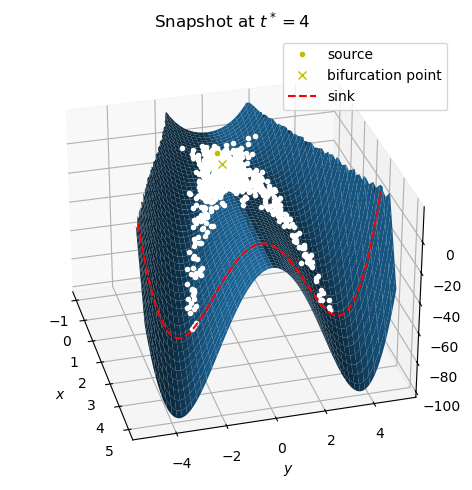

In [19]:
#~~~  Plot the 3d potential and the points sampled  ~~~#

fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(projection='3d', computed_zorder=False)

# Get the grid
x = np.linspace(*xlims, 200)
y = np.linspace(*ylims, 200)
xs, ys = np.meshgrid(x, y)
xy = np.array([xs.flatten(), ys.flatten()]).T

# Compute the potential over the grid
z = jax.vmap(phi)(xy)  # Shape (nx*ny, 2)

# Clipping
clip = 20
clip = 1 + z.max() if clip is None else clip
if clip < z.min():
    warnings.warn(f"Clip value {clip} is below minimum value to plot.")
    clip = z.max()
under_cutoff = z <= clip
plot_screen = np.ones(under_cutoff.shape)
plot_screen[~under_cutoff] = np.nan
z_plot = z * plot_screen

sc = ax.plot_surface(
    xs, ys, z_plot.reshape(xs.shape),
)

# Plot the cells
ax.plot(
    sampled_cells[:,0], sampled_cells[:,1],
    jax.vmap(phi)(sampled_cells),
    'w.'
)

# Plot the source point
ax.plot(*source_point, phi(source_point), 'y.', label='source')

# Plot the bifurcation point
ax.plot(x_crit, 0., phi([x_crit, 0]), 'yx', label='bifurcation point')

# Plot the sink curve
ys_sink = np.linspace(*ylims, 100)
xs_sink = x_sink * np.ones(ys_sink.shape)
phi_sink = jax.vmap(phi)(np.array([xs_sink, ys_sink]).T).reshape(xs_sink.shape)
phi_sink = np.where(phi_sink > clip, np.nan, phi_sink)
ax.plot(xs_sink, ys_sink, phi_sink, 'r--', label='sink')

ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.set_title(f"Snapshot at $t^*={tstar}$")
ax.legend()

ax.view_init(30, -15)

plt.tight_layout()

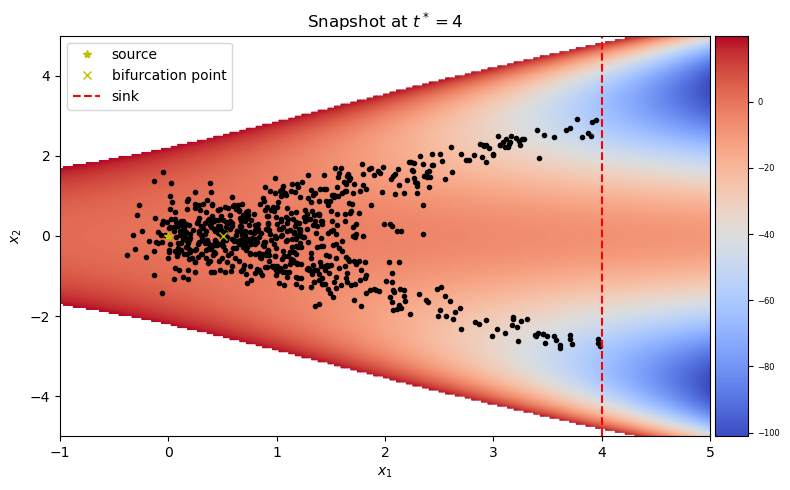

In [21]:
#~~~  Plot a 2d heatmap  ~~~#

fig, ax = plt.subplots(1, 1, figsize=(8,5))

xlims = [
    min(xlims[0], np.min(sampled_cells[:,0].min()) - 0.1),
    max(xlims[1], np.max(sampled_cells[:,0].max()) + 0.1),
]

ylims = [
    min(ylims[0], np.min(sampled_cells[:,1].min()) - 0.1),
    max(ylims[1], np.max(sampled_cells[:,1].max()) + 0.1),
]

# Get the grid
x = np.linspace(*xlims, 200)
y = np.linspace(*ylims, 200)
xs, ys = np.meshgrid(x, y)
xy = np.array([xs.flatten(), ys.flatten()]).T

# Compute the potential over the grid
z = jax.vmap(phi)(xy)  # Shape (nx*ny, 2)

# Clipping
clip = 20
clip = 1 + z.max() if clip is None else clip
if clip < z.min():
    warnings.warn(f"Clip value {clip} is below minimum value to plot.")
    clip = z.max()
under_cutoff = z <= clip
plot_screen = np.ones(under_cutoff.shape)
plot_screen[~under_cutoff] = np.nan
z_plot = z * plot_screen

sc = ax.pcolormesh(
    xs, ys, z_plot.reshape(xs.shape),
    vmin=z[under_cutoff].min(),
    vmax=z[under_cutoff].max(),
    cmap='coolwarm', 
    shading="gouraud",
)

# Colorbar
fig = ax.figure
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = fig.colorbar(sc, cax=cax)
cbar.ax.set_title("", size=6)
cbar.ax.tick_params(labelsize=6)

# Plot the cells
ax.plot(
    sampled_cells[:,0], sampled_cells[:,1],
    'k.'
)

# Plot the source point
ax.plot(*source_point, 'y*', label="source")

# Plot the bifurcation point
ax.plot(x_crit, 0., 'yx', label="bifurcation point")

# Plot the sink curve
ys_sink = np.linspace(*ylims, 100)
xs_sink = x_sink * np.ones(ys_sink.shape)
ax.plot(xs_sink, ys_sink, 'r--', label='sink',)

ax.legend()
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
ax.set_title(f"Snapshot at $t^*={tfin}$")

plt.tight_layout()

# Solving the PDE

We now turn to solving the Fokker-Planck equation.

In [24]:
import equinox as eqx
import jax.lax as lax
from typing import Callable
from jaxtyping import Array, Float
from ipywidgets import interact, IntSlider

In [25]:
#~~~  Solving the PDE  ~~~#

class SpatialDiscretisation(eqx.Module):
    """Represents the interval [x0, x_final] x [y0, y_final] discretised into 
    n x m equally-spaced points.

    """
    
    x0: float = eqx.field(static=True)
    x_final: float = eqx.field(static=True)
    y0: float = eqx.field(static=True)
    y_final: float = eqx.field(static=True)
    xs: Float[Array, "nx ny"]
    ys: Float[Array, "nx ny"]
    vals: Float[Array, "nx ny"]

    @classmethod
    def discretise_fn(
            cls, 
            x0: float, 
            x_final: float, 
            nx: int, 
            y0: float, 
            y_final: float, 
            ny: int, 
            fn: Callable
    ):
        if nx < 2:
            raise ValueError("Must discretise [x0, x_final] into at least two points")
        if ny < 2:
            raise ValueError("Must discretise [y0, y_final] into at least two points")
        x = np.linspace(x0, x_final, nx)
        y = np.linspace(y0, y_final, ny)
        xs, ys = np.meshgrid(x, y)
        vals = jax.vmap(fn)(xs.flatten(), ys.flatten()).reshape(xs.shape)
        return cls(x0, x_final, y0, y_final, xs, ys, vals)

    @property
    def δx(self):
        return (self.x_final - self.x0) / (self.vals.shape[1] - 1)
    
    @property
    def δy(self):
        return (self.y_final - self.y0) / (self.vals.shape[0] - 1)
    
    @property
    def nx(self):
        return self.vals.shape[1]
    
    @property
    def ny(self):
        return self.vals.shape[0]
    
    def apply_bc(self):
        new_vals = self.vals.at[0,:].set(0.)
        new_vals = new_vals.at[:,0].set(0.)
        new_vals = new_vals.at[:,-1].set(0.)
        new_vals = jnp.where(self.xs > x_sink, 0., new_vals)
        return SpatialDiscretisation(
            self.x0, self.x_final, self.y0, self.y_final, self.xs, self.ys, 
            new_vals
        )
    
    def normalize(self):
        new_vals = self.vals / (self.vals.sum() * self.δx * self.δx)
        return SpatialDiscretisation(
            self.x0, self.x_final, self.y0, self.y_final, self.xs, self.ys, 
            new_vals
        )
    
    def evaluate(self, x, y):
        nearest_x_idx = jnp.argmin(jnp.abs(x - self.xs[0,:]))
        nearest_y_idx = jnp.argmin(jnp.abs(y - self.ys[:,0]))
        return self.vals[nearest_x_idx, nearest_y_idx]
    
    def binop(self, other, fn):
        if isinstance(other, SpatialDiscretisation):
            x_mismatch = self.x0 != other.x0 or self.x_final != other.x_final
            y_mismatch = self.y0 != other.y0 or self.y_final != other.y_final
            if x_mismatch or y_mismatch:
                raise ValueError("Mismatched spatial discretisations")
            other = other.vals
        return SpatialDiscretisation(
            self.x0, self.x_final, self.y0, self.y_final, self.xs, self.ys, 
            fn(self.vals, other)
        )

    def __add__(self, other):
        return self.binop(other, lambda x, y: x + y)

    def __mul__(self, other):
        return self.binop(other, lambda x, y: x * y)

    def __radd__(self, other):
        return self.binop(other, lambda x, y: y + x)

    def __rmul__(self, other):
        return self.binop(other, lambda x, y: y * x)

    def __sub__(self, other):
        return self.binop(other, lambda x, y: x - y)

    def __rsub__(self, other):
        return self.binop(other, lambda x, y: y - x)


def laplacian(
        u: SpatialDiscretisation, 
        diffusivity_x: float, 
        diffusivity_y: float,
) -> SpatialDiscretisation:
    x_next = jnp.roll(u.vals, shift=-1, axis=1)
    x_prev = jnp.roll(u.vals, shift=1, axis=1)
    y_next = jnp.roll(u.vals, shift=-1, axis=0)
    y_prev = jnp.roll(u.vals, shift=1, axis=0)
    Δx = (x_next - 2 * u.vals + x_prev) / (u.δx**2)
    Δy = (y_next - 2 * u.vals + y_prev) / (u.δy**2)
    return SpatialDiscretisation(
        u.x0, u.x_final, u.y0, u.y_final, u.xs, u.ys, 
        diffusivity_x * Δx + diffusivity_y * Δy
    )

def partial_x(u: SpatialDiscretisation) -> SpatialDiscretisation:
    x_next = jnp.roll(u.vals, shift=-1, axis=1)
    x_prev = jnp.roll(u.vals, shift=1, axis=1)
    Δx = (x_next - x_prev) / (2*u.δx)
    return SpatialDiscretisation(
        u.x0, u.x_final, u.y0, u.y_final, u.xs, u.ys, Δx
    )

def partial_y(u: SpatialDiscretisation) -> SpatialDiscretisation:
    y_next = jnp.roll(u.vals, shift=-1, axis=0)
    y_prev = jnp.roll(u.vals, shift=1, axis=0)
    Δy = (y_next - y_prev) / (2*u.δy)
    return SpatialDiscretisation(
        u.x0, u.x_final, u.y0, u.y_final, u.xs, u.ys, Δy
    )

def div(u: SpatialDiscretisation) -> SpatialDiscretisation:
    x_next = jnp.roll(u.vals, shift=-1, axis=1)
    x_prev = jnp.roll(u.vals, shift=1, axis=1)
    y_next = jnp.roll(u.vals, shift=-1, axis=0)
    y_prev = jnp.roll(u.vals, shift=1, axis=0)
    Δx = (x_next - x_prev) / (2*u.δx)
    Δy = (y_next - y_prev) / (2*u.δy)
    return SpatialDiscretisation(
        u.x0, u.x_final, u.y0, u.y_final, u.xs, u.ys, Δx + Δy
    )

def grad_dot_v(
        u: SpatialDiscretisation,
        vx: SpatialDiscretisation,
        vy: SpatialDiscretisation,
) -> SpatialDiscretisation:
    dx = partial_x(u)
    dy = partial_y(u)
    return SpatialDiscretisation(
        u.x0, u.x_final, u.y0, u.y_final, u.xs, u.ys,
        dx.vals * vx.vals + dy.vals * vy.vals
    )


In [26]:
#~~~  Examples of the SpatialDiscretisation class  ~~~#

w = SpatialDiscretisation.discretise_fn(
    0, 4, 5, 0, 2, 3, 
    lambda x, y: x**2 + y
)

def pot(x):
    return 1. * x[0] + 2. * x[1]*x[1]

w2 = SpatialDiscretisation.discretise_fn(
    0, 4, 5, 0, 2, 3, 
    lambda x, y: jax.grad(pot)(jnp.array([x, y]))[1]
)

print(w2.vals)

[[0. 0. 0. 0. 0.]
 [4. 4. 4. 4. 4.]
 [8. 8. 8. 8. 8.]]


In [27]:
def grad_phi(x):
    return jax.grad(phi)(x)

def grad_phi_x(x):
    return grad_phi(x)[0]

def grad_phi_y(x):
    return grad_phi(x)[1]

def ddx_grad_phi_x(x):
    return jax.grad(grad_phi_x)(x)[0]

def ddy_grad_phi_y(x):
    return jax.grad(grad_phi_y)(x)[1]

x = jnp.array([2, 1], dtype=jnp.float64)

print(grad_phi(x))
print(grad_phi_x(x))
print(grad_phi_y(x))
print(ddx_grad_phi_x(x))
print(ddy_grad_phi_y(x))

[-5. -7.]
-5.0
-7.0
0.0
-3.0


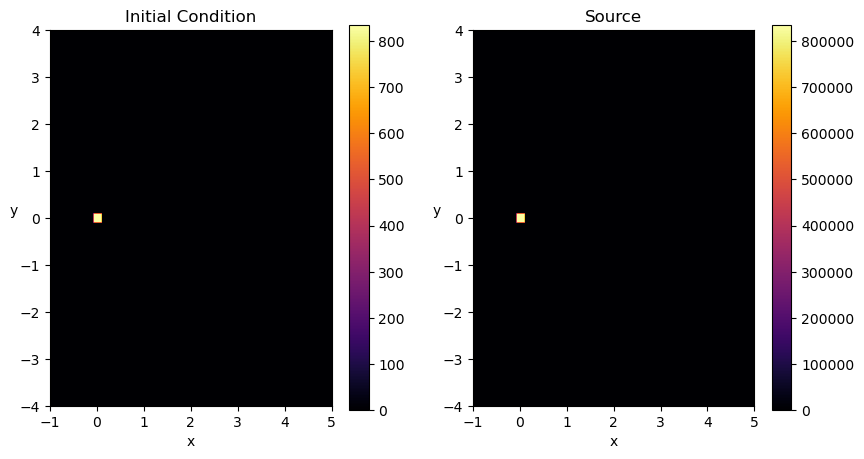

In [28]:
s_rate = r

def ic(x, y, dx=1., dy=1., x0=0, y0=0, sigma_x=1., sigma_y=1.):
    # return jnp.exp(
    #     -((x - x0)**2/(2 * sigma_x**2) + (y - y0)**2/(2 * sigma_y**2))
    # )
    eps = 1e-1
    p = 1./(dx*dy) \
            * (x >= source_point[0] - eps) * (x <= source_point[0] + eps) \
            * (y >= source_point[1] - eps) * (y <= source_point[1] + eps)
    return p
           
def source_condition(x, y, source_rate, dx, dy):
    eps = 1e-1
    return source_rate / (dx*dy) \
                * (x >= source_point[0] - eps) * (x <= source_point[0] + eps) \
                * (y >= source_point[1] - eps) * (y <= source_point[1] + eps) \

# Spatial discretisation
x0 = -1
x_final = 5
y0 = -4
y_final = 4
nx = 201
ny = 201

dx = (x_final - x0) / (nx - 1)
dy = (y_final - y0) / (ny - 1)

p0 = SpatialDiscretisation.discretise_fn(
    x0, x_final, nx, y0, y_final, ny, 
    lambda x, y: ic(x, y, dx=dx, dy=dy)
)
p0 = p0.apply_bc()

source_field = SpatialDiscretisation.discretise_fn(
    x0, x_final, nx, y0, y_final, ny, 
    lambda x, y: source_condition(x, y, source_rate=s_rate, dx=dx, dy=dy)
)

gphi_x = SpatialDiscretisation.discretise_fn(
    x0, x_final, nx, y0, y_final, ny, 
    lambda x, y: grad_phi_x(jnp.array([x, y], dtype=jnp.float64))
)

gphi_y = SpatialDiscretisation.discretise_fn(
    x0, x_final, nx, y0, y_final, ny, 
    lambda x, y: grad_phi_y(jnp.array([x, y], dtype=jnp.float64))
)

ddx_gphi_x = SpatialDiscretisation.discretise_fn(
    x0, x_final, nx, y0, y_final, ny, 
    lambda x, y: ddx_grad_phi_x(jnp.array([x, y], dtype=jnp.float64))
)

ddy_gphi_y = SpatialDiscretisation.discretise_fn(
    x0, x_final, nx, y0, y_final, ny, 
    lambda x, y: ddy_grad_phi_y(jnp.array([x, y], dtype=jnp.float64))
)

div_gphi = ddx_gphi_x + ddy_gphi_y

# Problem
def dpdt(t, p, args):
    return div_gphi * p + grad_dot_v(p, gphi_x, gphi_y) \
        + laplacian(p, diffusivity_x, diffusivity_y) + source_field
    
term = dfrx.ODETerm(dpdt)


fig, axes = plt.subplots(1, 2, figsize=(10,5))

# Plot initial condition
ax = axes[0]
image = ax.imshow(
    p0.vals,
    origin="lower",
    extent=(x0, x_final, y0, y_final),
    aspect='equal',
    cmap="inferno",
)
ax.set_title("Initial Condition")
ax.set_xlabel("x")
ax.set_ylabel("y", rotation=0)
plt.colorbar(image)
image.set_clim(p0.vals.min(), p0.vals.max())


# Plot source
ax = axes[1]
image = ax.imshow(
    source_field.vals,
    origin="lower",
    extent=(x0, x_final, y0, y_final),
    aspect='equal',
    cmap="inferno",
)
ax.set_title("Source")
ax.set_xlabel("x")
ax.set_ylabel("y", rotation=0)
plt.colorbar(image)
image.set_clim(source_field.vals.min(), source_field.vals.max())


plt.show()

In [29]:
#~~~  Solving with a solver without boundary conditions  ~~~#

# Temporal discretisation
t0 = 0
t_final = 3
δt = 0.001
saveat = dfrx.SaveAt(ts=jnp.linspace(t0, t_final, 101))

# Tolerances
rtol = 1e-5
atol = 1e-5
stepsize_controller = dfrx.PIDController(
    pcoeff=0.3, icoeff=0.4, rtol=rtol, atol=atol, dtmin=1e-5, dtmax=1e-3
)

solver = dfrx.Tsit5()
sol = dfrx.diffeqsolve(
    term,
    solver,
    t0,
    t_final,
    δt,
    p0,
    saveat=saveat,
    stepsize_controller=stepsize_controller,
    max_steps=None,
)

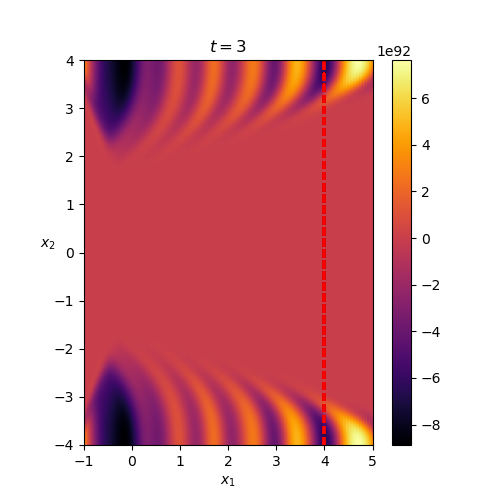

interactive(children=(IntSlider(value=0, description='i', max=101), Output()), _dom_classes=('widget-interact'…

In [30]:
%matplotlib widget

fig, ax = plt.subplots(1, 1, figsize=(5,5))
image = ax.imshow(
    sol.ys.vals[-1],
    origin="lower",
    extent=(x0, x_final, y0, y_final),
    aspect='equal',
    cmap="inferno",
)

ys_sink = sol.ys.ys[0]
xs_sink = x_sink * np.ones(ys_sink.shape)
ax.plot(xs_sink, ys_sink, 'r--')

ax.set_title(f"$t={t_final}$")
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$", rotation=0)
plt.colorbar(image)
plt.show()

def update_plot(i):
    t = sol.ts[i]
    u = sol.ys.vals[i]
    image.set_data(u)
    image.set_clim(u.min(), u.max())
    ax.set_title(f"t={t:.3f}")
    

interact(
    update_plot, 
    i=IntSlider(
        value=0, min=0, max=len(sol.ys.vals), step=1, 
        description='i'
    )
)

plt.tight_layout()

## Using a custom solver and applying boundary conditions

In [32]:
class CrankNicolson(dfrx.AbstractSolver):
    rtol: float
    atol: float

    term_structure = dfrx.ODETerm
    interpolation_cls = dfrx.LocalLinearInterpolation

    def order(self, terms):
        return 2

    def init(self, terms, t0, t1, y0, args):
        return None

    def step(self, terms, t0, t1, y0, args, solver_state, made_jump):
        del solver_state, made_jump
        δt = t1 - t0 
        f0 = terms.vf(t0, y0, args)

        def keep_iterating(val):
            _, not_converged = val
            return not_converged

        @eqx.filter_jit
        def fixed_point_iteration(val):
            y1, _ = val
            new_y1 = y0 + 0.5 * δt * (f0 + terms.vf(t1, y1, args))
            new_y1 = new_y1.apply_bc()
            diff = jnp.abs((new_y1 - y1).vals)
            max_y1 = jnp.maximum(jnp.abs(y1.vals), jnp.abs(new_y1.vals))
            scale = self.atol + self.rtol * max_y1
            not_converged = jnp.any(diff > scale)
            return new_y1, not_converged

        euler_y1 = y0 + δt * f0
        euler_y1 = euler_y1.apply_bc()
        y1, _ = lax.while_loop(keep_iterating, fixed_point_iteration, (euler_y1, False))

        y_error = y1 - euler_y1
        dense_info = dict(y0=y0, y1=y1)

        solver_state = None
        result = dfrx.RESULTS.successful
        return y1, y_error, dense_info, solver_state, result

    def func(self, terms, t0, y0, args):
        return terms.vf(t0, y0, args)


In [33]:
# Temporal discretisation
t0 = 0
t_final = 3
dt = 0.00001
saveat = dfrx.SaveAt(ts=jnp.linspace(t0, t_final, 101))

# Tolerances
rtol = 1e-4
atol = 1e-4
# stepsize_controller = dfrx.PIDController(
#     pcoeff=0.3, icoeff=0.4, rtol=rtol, atol=atol, dtmin=1e-6, dtmax=1e-1
# )
stepsize_controller = dfrx.ConstantStepSize()

# discrete_terminating_event = dfrx.SteadyStateEvent(norm=lambda x: 0.)

solver = CrankNicolson(rtol=rtol, atol=atol)
sol = dfrx.diffeqsolve(
    term,
    solver,
    t0,
    t_final,
    dt,
    p0,
    saveat=saveat,
    stepsize_controller=stepsize_controller,
    # discrete_terminating_event=discrete_terminating_event,
    max_steps=None,
)

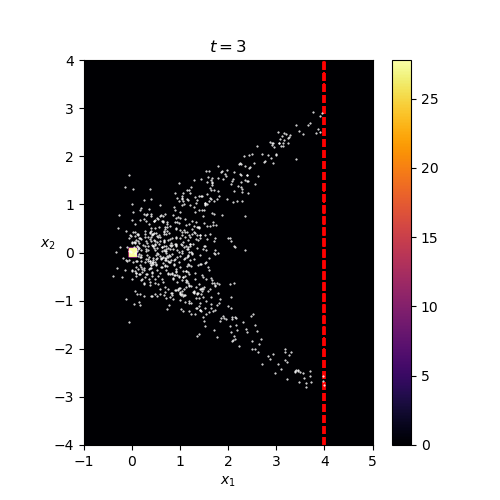

interactive(children=(IntSlider(value=0, description='i', max=101), Output()), _dom_classes=('widget-interact'…

In [35]:
%matplotlib widget

fig, ax = plt.subplots(1, 1, figsize=(5,5))
normalization_cache = {}
normalization_cache[0] = sol.ys.vals[0].sum() * p0.δx * p0.δy
image = ax.imshow(
    sol.ys.vals[0] / normalization_cache[0],
    origin="lower",
    extent=(x0, x_final, y0, y_final),
    aspect='equal',
    cmap="inferno",
)

ys_sink = sol.ys.ys[0]
xs_sink = x_sink * np.ones(ys_sink.shape)
ax.plot(xs_sink, ys_sink, 'r--')

ax.set_title(f"$t={t_final}$")
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$", rotation=0)
plt.colorbar(image)

# Plot the cells
ax.plot(
    sampled_cells[:,0], sampled_cells[:,1],
    '.', color='white', markersize=1,
)

plt.show()

def update_plot(i):
    t = sol.ts[i]
    u = sol.ys.vals[i]
    if i in normalization_cache:
        u = u / normalization_cache[i]
    else:
        norm_u = u.sum() * p0.δx * p0.δy
        normalization_cache[i] = norm_u
        u = u / norm_u
    image.set_data(u)
    image.set_clim(u.min(), u.max())
    ax.set_title(f"t={t:.3f}")
    

interact(
    update_plot, 
    i=IntSlider(
        value=0, min=0, max=len(sol.ys.vals), step=1, 
        description='i'
    )
)

plt.tight_layout()

In [28]:
y_last = sol.ys.vals[-1]
y_penu = sol.ys.vals[-2]

jnp.square(y_last - y_penu).max()

Array(4.81180301e-17, dtype=float64)

Loss: 4.807435155016587


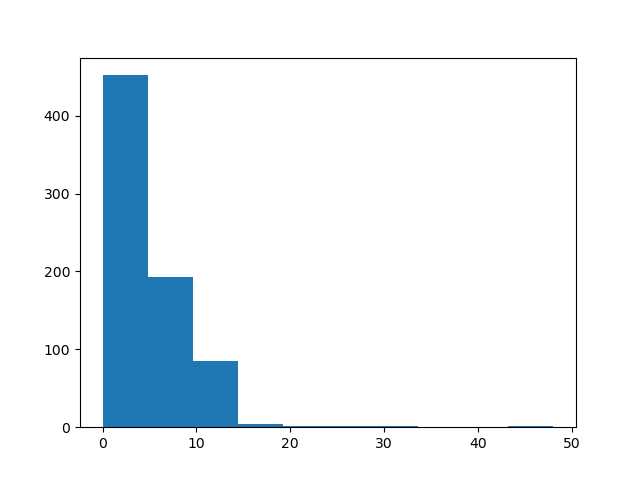

In [36]:
p_ss = SpatialDiscretisation(
    p0.x0, p0.x_final, p0.y0, p0.y_final, p0.xs, p0.ys, 
    sol.ys.vals[-1] / (sol.ys.vals[-1].sum() * p0.δx * p0.δy)
)

logprobs = jnp.log(
    jax.vmap(p_ss.evaluate)(sampled_cells[:,0], sampled_cells[:,1])
)
logprobs = jnp.where(
    jnp.logical_or(jnp.isnan(logprobs), jnp.isinf(logprobs)), 0, logprobs
)
print("Loss:", -jnp.mean(logprobs))


fig, ax = plt.subplots(1, 1)
ax.hist(-logprobs)
plt.show()

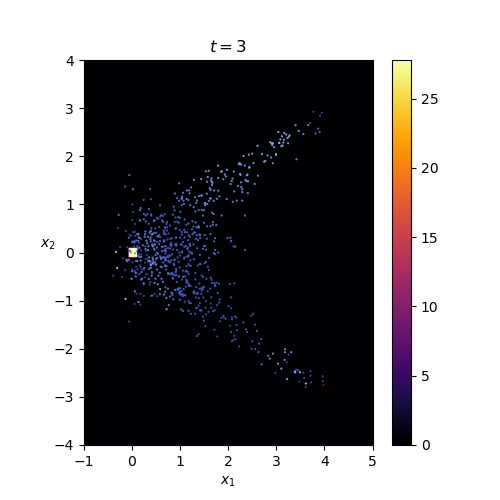

interactive(children=(IntSlider(value=0, description='i', max=101), Output()), _dom_classes=('widget-interact'…

In [37]:
%matplotlib widget

fig, ax = plt.subplots(1, 1, figsize=(5,5))
normalization_cache = {}
normalization_cache[0] = sol.ys.vals[0].sum() * p0.δx * p0.δy
image = ax.imshow(
    sol.ys.vals[0] / normalization_cache[0],
    origin="lower",
    extent=(x0, x_final, y0, y_final),
    aspect='equal',
    cmap="inferno",
)
ax.set_title(f"$t={t_final}$")
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$", rotation=0)
plt.colorbar(image)

# Plot the cells
ax.scatter(
    sampled_cells[:,0], sampled_cells[:,1],
    marker='.', c=-logprobs, cmap='coolwarm', s=1,
)


plt.show()

def update_plot(i):
    t = sol.ts[i]
    u = sol.ys.vals[i]
    if i in normalization_cache:
        u = u / normalization_cache[i]
    else:
        norm_u = u.sum() * p0.δx * p0.δy
        normalization_cache[i] = norm_u
        u = u / norm_u
    image.set_data(u)
    image.set_clim(u.min(), u.max())
    ax.set_title(f"t={t:.3f}")
    

interact(
    update_plot, 
    i=IntSlider(
        value=0, min=0, max=len(sol.ys.vals), step=1, 
        description='i'
    )
)

plt.tight_layout()

## Defining a Loss Function

In [38]:
def loss_function(p_ss, observed_points):
    logprobs = jnp.log(
        jax.vmap(p_ss.evaluate)(observed_points[:,0], observed_points[:,1])
    )
    logprobs = jnp.where(
        jnp.logical_or(jnp.isnan(logprobs), jnp.isinf(logprobs)), 0, logprobs
    )
    return -jnp.mean(logprobs)

print(loss_function(p_ss, sampled_cells))

4.807435155016587


## Defining a Model

In [39]:
class LandscapeModel(eqx.Module):

    mlp: eqx.Module

    def __init__(self, key):
        key, subkey = jrandom.split(key, 2)
        self.mlp = eqx.nn.MLP(
            in_size=2,
            out_size='scalar',
            width_size=8,
            depth=4,
            activation=jax.nn.softplus,
            use_final_bias=False,
            dtype=jnp.float64,
            key=subkey,
        )

    def phi(self, x):
        return self.mlp(x)
    

In [33]:
model = LandscapeModel(key)

model.mlp(np.array([0, 1]))


Array(0.34291575, dtype=float64)

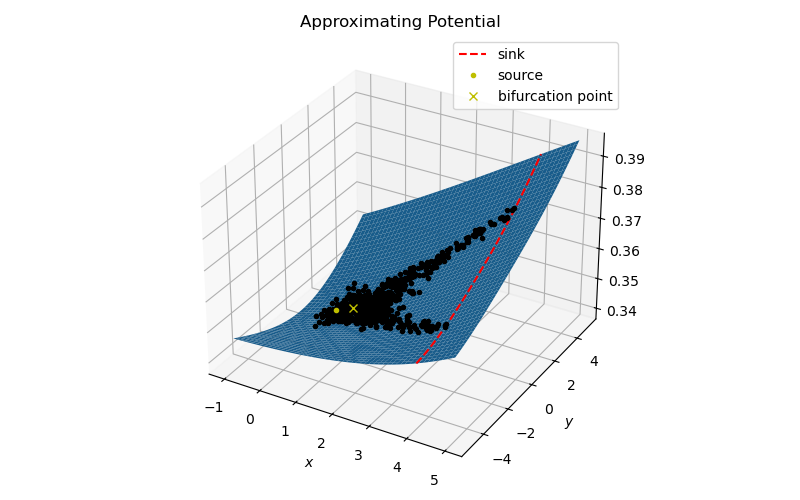

In [34]:
#~~~  Plot the 3d potential and the points sampled  ~~~#

fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(projection='3d', computed_zorder=False)

# Get the grid
x = np.linspace(*xlims, 200)
y = np.linspace(*ylims, 200)
xs, ys = np.meshgrid(x, y)
xy = np.array([xs.flatten(), ys.flatten()]).T

# Compute the potential over the grid
z = jax.vmap(model.mlp)(xy)

# Clipping
clip = 10
clip = 1 + z.max() if clip is None else clip
if clip < z.min():
    warnings.warn(f"Clip value {clip} is below minimum value to plot.")
    clip = z.max()
under_cutoff = z <= clip
plot_screen = np.ones(under_cutoff.shape)
plot_screen[~under_cutoff] = np.nan
z_plot = z * plot_screen

sc = ax.plot_surface(
    xs, ys, z_plot.reshape(xs.shape),
)

# Plot the sink curve
ys_sink = np.linspace(*ylims, 100)
xs_sink = x_sink * np.ones(ys_sink.shape)
phi_sink = jax.vmap(model.mlp)(np.array([xs_sink, ys_sink]).T).reshape(xs_sink.shape)
phi_sink = np.where(phi_sink > clip, np.nan, phi_sink)
ax.plot(xs_sink, ys_sink, phi_sink, 'r--', label='sink')

# Plot the cells
ax.plot(
    sampled_cells[:,0], sampled_cells[:,1],
    jax.vmap(model.mlp)(sampled_cells),
    'k.'
)

# Plot the source point
ax.plot(*source_point, model.mlp(jnp.array(source_point)), 'y.', label='source')

# Plot the bifurcation point
ax.plot(x_crit, 0., model.mlp(jnp.array([x_crit, 0])), 'yx', label='bifurcation point')

ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.set_title("Approximating Potential")
ax.legend()

ax.view_init(30, -60)

plt.tight_layout()